<a href="https://colab.research.google.com/github/kavrit/NYC-Taxi-trip-prediction/blob/main/Capstone_Project_NYC_Taxi_Trip_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
#import required packages and libraries
!pip install haversine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from haversine import haversine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#set style for graph
sns.set_style(style='darkgrid')

# Setting fontsizes,fontweight,label weight for labels,titles.
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.title_fontsize"] = 15

## **Data Preparation**

### **Mounting Drive**

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1RMrMAQ3-Al8j6s4WLnPM3FieUkZNrPRY/view?usp=sharing'
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('NYC Taxi Data.csv') 
 
df = pd.read_csv('NYC Taxi Data.csv')

### **Data Inspection**

In [4]:
#first look checking top 5 rows
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1048570,id0002921,1,06-04-2016 14:16,06-04-2016 14:20,1,-73.973015,40.760948,-73.976387,40.755604,N,207
1048571,id1329189,2,24-03-2016 01:26,24-03-2016 01:38,1,-73.985550,40.727257,-73.957039,40.712387,N,740
1048572,id0408460,1,23-02-2016 16:38,23-02-2016 16:48,1,-73.972038,40.750202,-73.998360,40.733360,N,605
1048573,id0147762,1,24-05-2016 07:20,24-05-2016 07:25,1,-73.993332,40.724342,-74.004250,40.707470,N,287
1048574,id0859354,2,15-03-2016 22:00,15-03-2016 22:19,1,-73.988060,40.759548,-74.005585,40.711521,N,1169


In [6]:
#check information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1048575 non-null  object 
 1   vendor_id           1048575 non-null  int64  
 2   pickup_datetime     1048575 non-null  object 
 3   dropoff_datetime    1048575 non-null  object 
 4   passenger_count     1048575 non-null  int64  
 5   pickup_longitude    1048575 non-null  float64
 6   pickup_latitude     1048575 non-null  float64
 7   dropoff_longitude   1048575 non-null  float64
 8   dropoff_latitude    1048575 non-null  float64
 9   store_and_fwd_flag  1048575 non-null  object 
 10  trip_duration       1048575 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 88.0+ MB


In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1048575,1048575,id2875421,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vendor_id,1048575.0,NaN,NaN,NaN,1.534503,0.498808,1.0,1.0,2.0,2.0,2.0
pickup_datetime,1048575,237127,23-04-2016 21:23,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_datetime,1048575,237442,21-01-2016 22:52,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,1048575.0,NaN,NaN,NaN,1.664382,1.314261,0.0,1.0,1.0,2.0,9.0
pickup_longitude,1048575.0,NaN,NaN,NaN,-73.97342,0.042802,-78.547401,-73.991859,-73.981735,-73.967308,-61.335529
pickup_latitude,1048575.0,NaN,NaN,NaN,40.750942,0.033814,34.359695,40.737377,40.75415,40.768364,51.881084
dropoff_longitude,1048575.0,NaN,NaN,NaN,-73.973361,0.042743,-79.817978,-73.99131,-73.979729,-73.963005,-61.335529
dropoff_latitude,1048575.0,NaN,NaN,NaN,40.751834,0.03645,32.181141,40.735939,40.754551,40.76984,43.911762
store_and_fwd_flag,1048575,2,N,1042766,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#check columns names
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [9]:
#Check shape of dataset
df.shape 

(1048575, 11)

### **Data Description**

*   id - a unique identifier for each trip
*   vendor_id - a code indicating the provider associated with the trip record
*   pickup_datetime - date and time when the meter was engaged
*   dropoff_datetime - date and time when the meter was disengaged
*   passenger_count - the number of passengers in the vehicle (driver entered value)
*   pickup_longitude - the longitude where the meter was engaged
*   pickup_latitude - the latitude where the meter was engaged
*   dropoff_longitude - the longitude where the meter was disengaged
*   dropoff_latitude - the latitude where the meter was disengaged
*   store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
*   trip_duration - duration of the trip in seconds



In [10]:
#first create copy of dataset before working with so that we have original data untouched
df1 = df.copy()

### **Check columns and their unique values to understand what they contain.**

In [11]:
#check unique values for categorical columnns
categorical_columns = df1.select_dtypes(include=['object'])
for col in categorical_columns:
  print(f'Unique values in categorical columns {col} are: {categorical_columns[col].unique()[:8]}\n')

Unique values in categorical columns id are: ['id2875421' 'id2377394' 'id3858529' 'id3504673' 'id2181028' 'id0801584'
 'id1813257' 'id1324603']

Unique values in categorical columns pickup_datetime are: ['14-03-2016 17:24' '12-06-2016 00:43' '19-01-2016 11:35'
 '06-04-2016 19:32' '26-03-2016 13:30' '30-01-2016 22:01'
 '17-06-2016 22:34' '21-05-2016 07:54']

Unique values in categorical columns dropoff_datetime are: ['14-03-2016 17:32' '12-06-2016 00:54' '19-01-2016 12:10'
 '06-04-2016 19:39' '26-03-2016 13:38' '30-01-2016 22:09'
 '17-06-2016 22:40' '21-05-2016 08:20']

Unique values in categorical columns store_and_fwd_flag are: ['N' 'Y']



In [12]:
#check unique values for numerical columns
numerical_columns = df1._get_numeric_data()
for col in numerical_columns:
  print(f'Unique values in numerical columns {col} are: {numerical_columns[col].unique()[:8]}\n')

Unique values in numerical columns vendor_id are: [2 1]

Unique values in numerical columns passenger_count are: [1 6 4 2 3 5 0 7]

Unique values in numerical columns pickup_longitude are: [-73.98215485 -73.98041534 -73.97902679 -74.01004028 -73.97305298
 -73.98285675 -73.96901703 -73.96927643]

Unique values in numerical columns pickup_latitude are: [40.76793671 40.73856354 40.7639389  40.7199707  40.79320908 40.74219513
 40.7578392  40.79777908]

Unique values in numerical columns dropoff_longitude are: [-73.96463013 -73.9994812  -74.00533295 -74.01226807 -73.97292328
 -73.99208069 -73.95740509 -73.92247009]

Unique values in numerical columns dropoff_latitude are: [40.76560211 40.73115158 40.71008682 40.70671844 40.78252029 40.74918365
 40.76589584 40.76055908]

Unique values in numerical columns trip_duration are: [ 455  663 2124  429  435  443  341 1551]



In [13]:
#check count of unqiue id
len(df1['id'].unique())

1048575

In [14]:
#Convert timestamp to datetime format to fetch the other details as listed below
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [15]:
#check count of unqiue id
len(df1['id'].unique())

1048575

In [16]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
df['weekday'] = df.pickup_datetime.dt.weekday
df['month'] = df.pickup_datetime.dt.month
df['weekday_num'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [17]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [18]:
#Calculate distance and assign new column to the dataframe.
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

In [19]:
#Calculate Speed in km/h for further insights
df['speed'] = (df.distance/(df.trip_duration/3600))

In [20]:
#Check the type of each variable
df.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [21]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(df.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

In [22]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-12-06 00:43:00,2016-12-06 00:54:00,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-06-04 19:32:00,2016-06-04 19:39:00,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:00,2016-03-26 13:38:00,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


Now our dataset is complete for the further analysis before we train our model with optimal variables.

### **Handling missing values.**

In [23]:
#check null values
df1.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

As we can see there are no null values in our dataset.

In [24]:
df['id'].value_counts()

id2875421    1
id3505385    1
id1499125    1
id0691227    1
id1682481    1
            ..
id0154336    1
id2546928    1
id3154693    1
id1097988    1
id0859354    1
Name: id, Length: 1048575, dtype: int64

## **EDA**

### **Total Trip per hour**

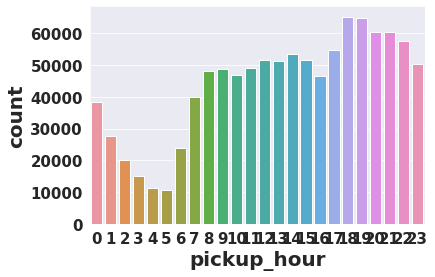

In [25]:
sns.countplot(df.pickup_hour)
plt.show()

### **Inference**

It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

### **Total trips per weekday**

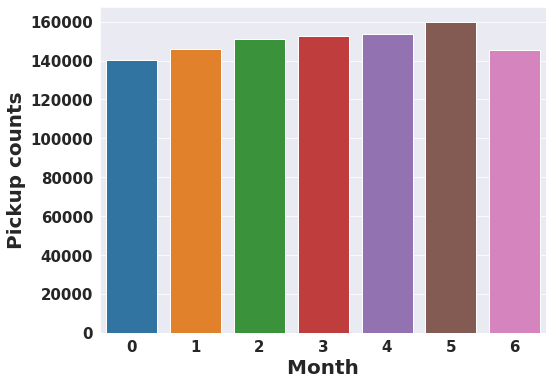

In [26]:
#Let's take a look now at the distribution of taxi pickups across the week.
plt.figure(figsize = (8,6))
sns.countplot(df.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

### **Observation**

Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

### **Trip Duration per hour**

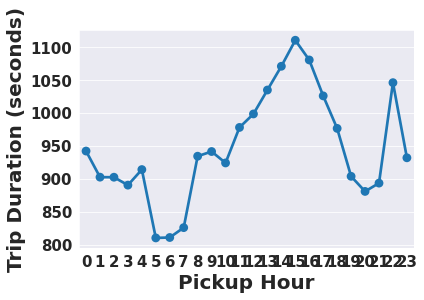

In [27]:
group1 = df.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

### **Observations**

Average trip duration is lowest at 6 AM when there is minimal traffic on the roads.

Average trip duration is generally highest around 3 PM during the busy streets

Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

### **Trip Duration per weekdays**

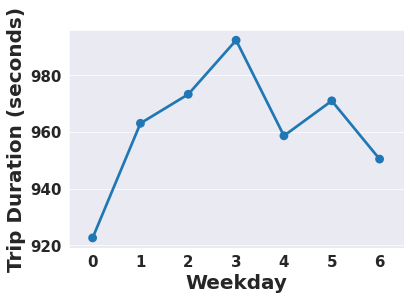

In [28]:
group2 = df.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

### **Trip duration per month**

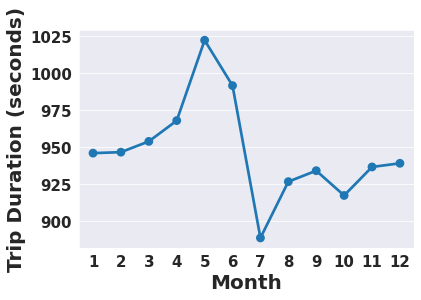

In [29]:
group3 = df.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

### **Observations**

We can see an increasing trend in the average trip duration along with each subsequent month.

The duration difference between each month is not much. It has increased gradually over a period of 6 months.

It is lowest during february when winters starts declining.

There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. Like May is generally the considered as the wettest month in NYC and which is inline with our visualization.
 As it generally takes longer on the roads due to traffic jams during rainy season. So natually the trip duration would increase towards April May and June.

### **Trip Duration per vendor**

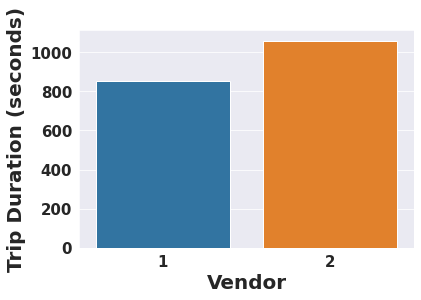

In [30]:
group4 = df.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.